In [88]:
import sys
sys.path.insert(1, './imports')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from exploratory_analysis import *
from preprocessing import *

In [2]:
fires = pd.read_csv("fires.csv")

## Counting NAs

In [3]:
fires.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

The dataset has no NA values

## Exploring discrete/categorical variables

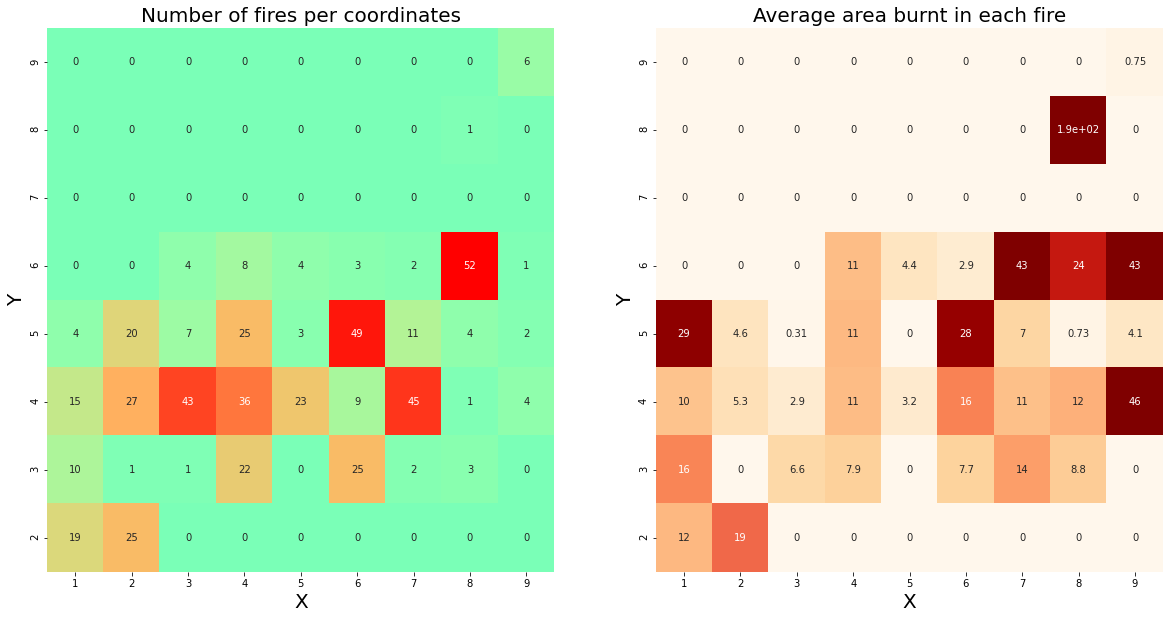

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
g1 = plot_xy_counts(fires, ax1)
g2 = plot_xy_averages(fires, ax2)
plt.show()

### Considering only the cases where area > 0

<AxesSubplot:title={'center':'Average area burnt when area > 0'}, xlabel='X', ylabel='Y'>

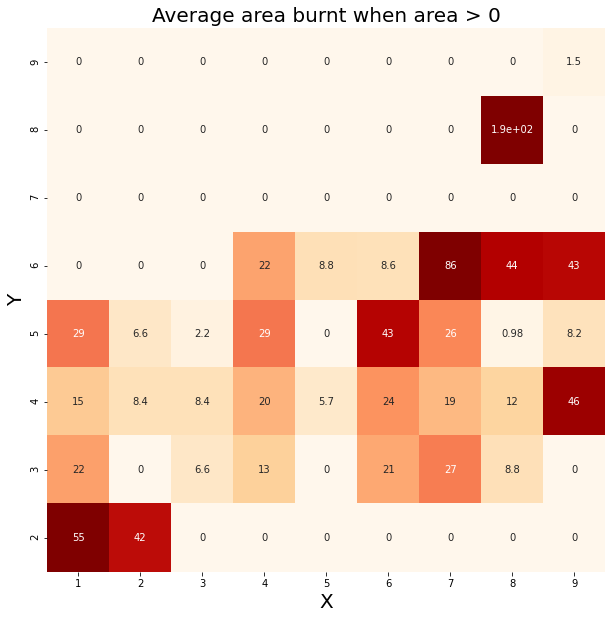

In [5]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
nonzero_fires = fires[fires["area"]!=0]
plot_xy_averages(nonzero_fires, ax, title = "Average area burnt when area > 0", vmax=50)

We can observe:

- The distribution of fires is non-uniform, a lot of parcels have no fires
- As expected the spatial data is clearly non-normal
- Apparently there's to some degree an inverse correlation between the number of fires and the area burnt, which totally makes sense.
- There seems to be a hotspot of fires around [6, 8] botg ub frequency and intensity
- The detectability of the fires can be different for the different areas. 

Consequences:

- The data should be transformed
- Since a priori the data (tabular, not a big number of observations) could probably be a good target for tree classifers (Random forest, gradient boost...), feature engineering for capturing the spatial effects could be an advantage.

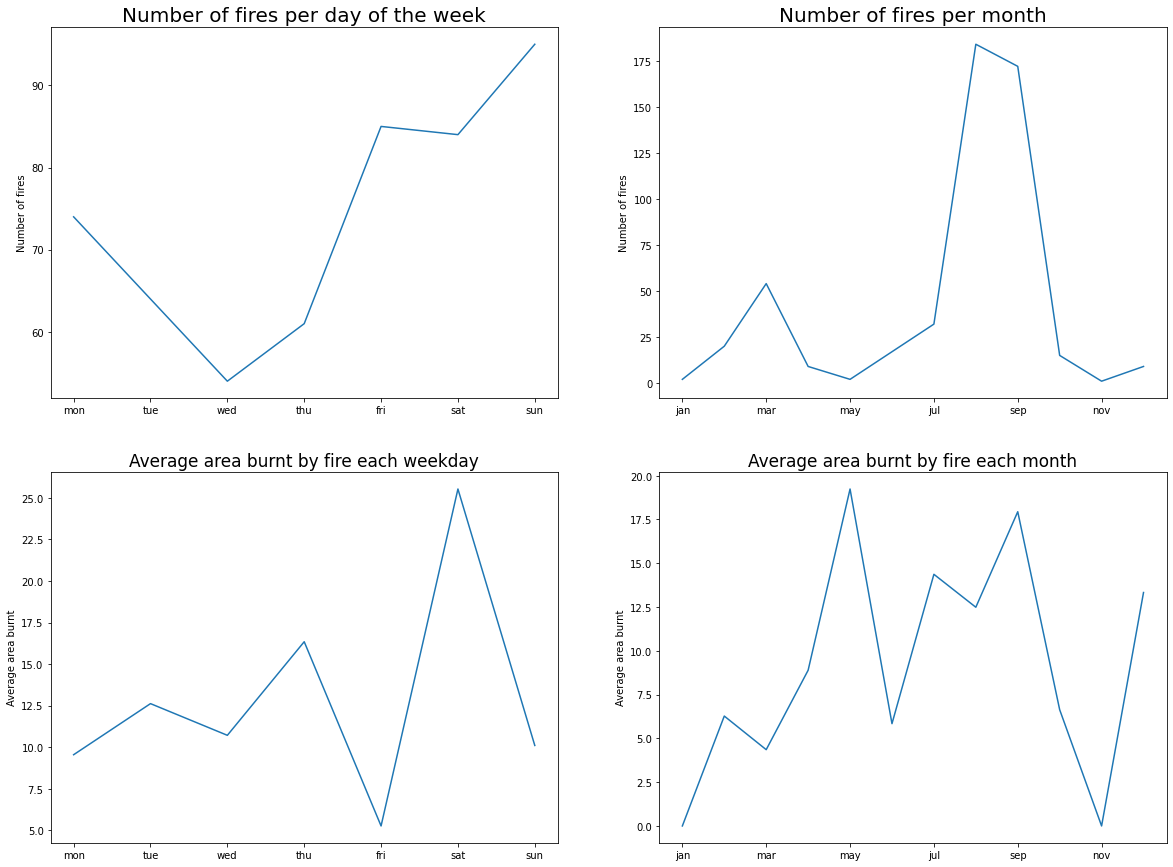

In [6]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
g1 = plot_weekday_counts(fires, ax1)
g2 = plot_month_counts(fires, ax2)
g3 = plot_weekday_averages(fires, ax3)
g4 = plot_month_averages(fires, ax4)
plt.show()

We can observe:

- The distribution of fires is non-uniform both along the months and the weekdays. The weekly pattern suggest that an important fraction of the fires could be unintetional burnings due to human activity or even arsons. The distribution along the year could be again related to human activity (between february and april and during the summer there are holidays), and of course the effect of the weather, with usually dry summers.
- There seems to be differences between the different months and days of the week about the average area burnt by fire, but there's no clear pattern.

Consequences:

- Data should be transformed
- One-hot encoding should be an appropiate transformation of the data


## Exploring continuous variables

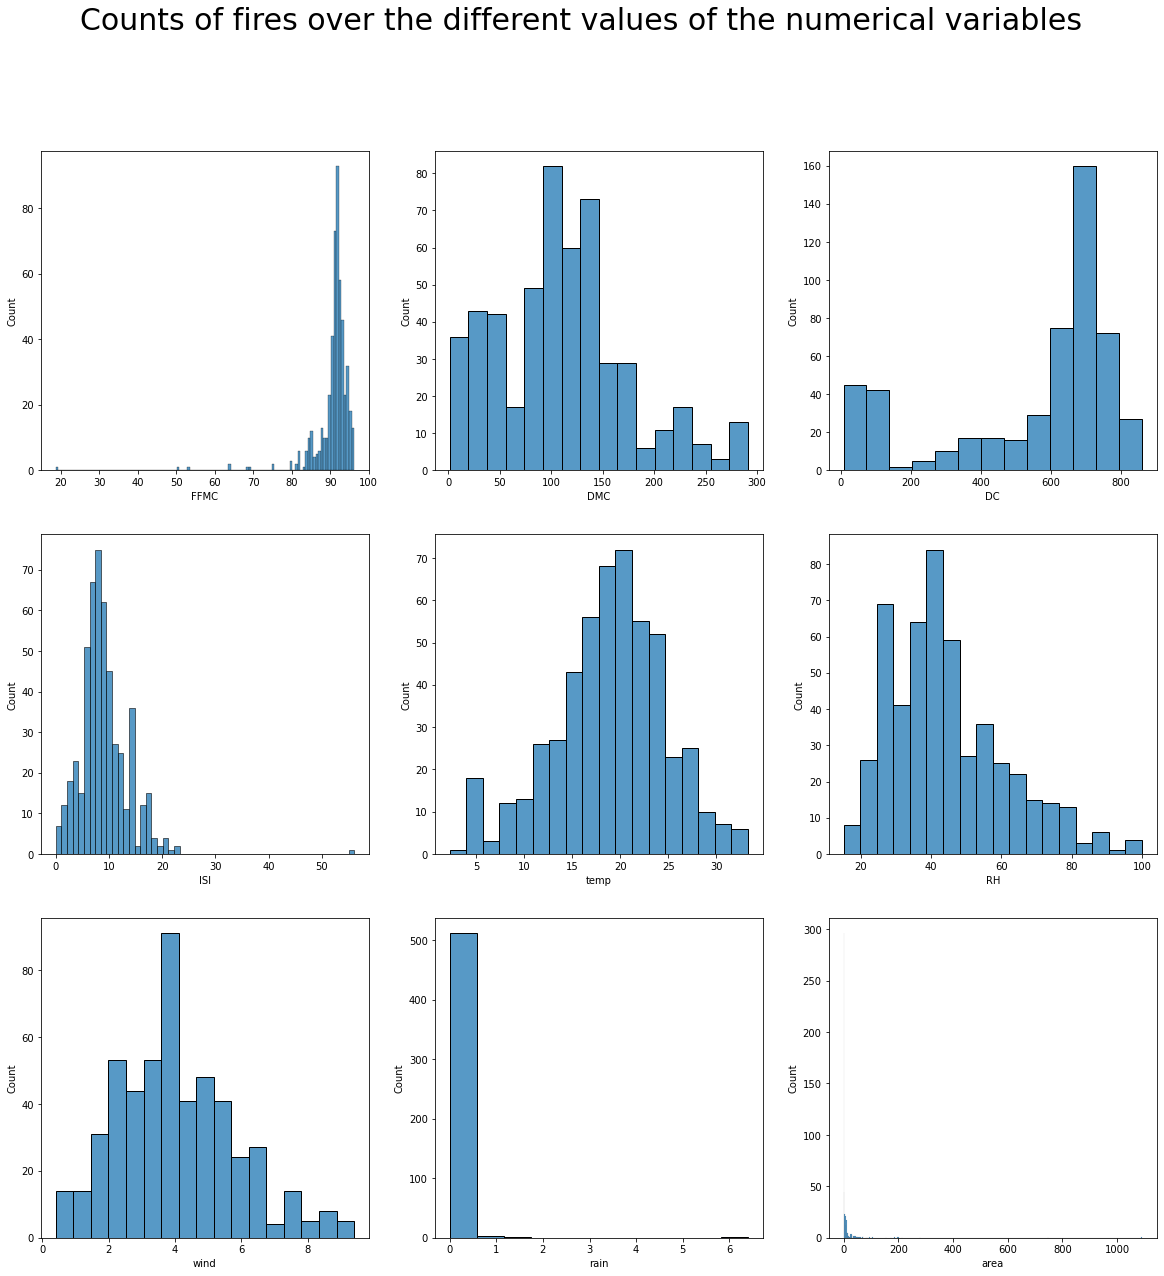

In [7]:
plot_numerical_counts(fires)

We can observe:

- Temp, and wind are probably close to being gaussian variables: Centering them should be enough and even could be unnecessary depending on the model.
- In FFMC, rain, ISI there are some outliers: They have to be dealt with.
- Rain and area have low resolution in this scale where a lot of values tend to be zero: one-hot enconding the zero and further exploration is necessary.
- DMC,ISI and RH seem close to normality but slightly skewed, probably some transormation would be benefitial.
- The distribution of FFMC and DC should be further explored to find a suitable transformation.

### Exploring "area"

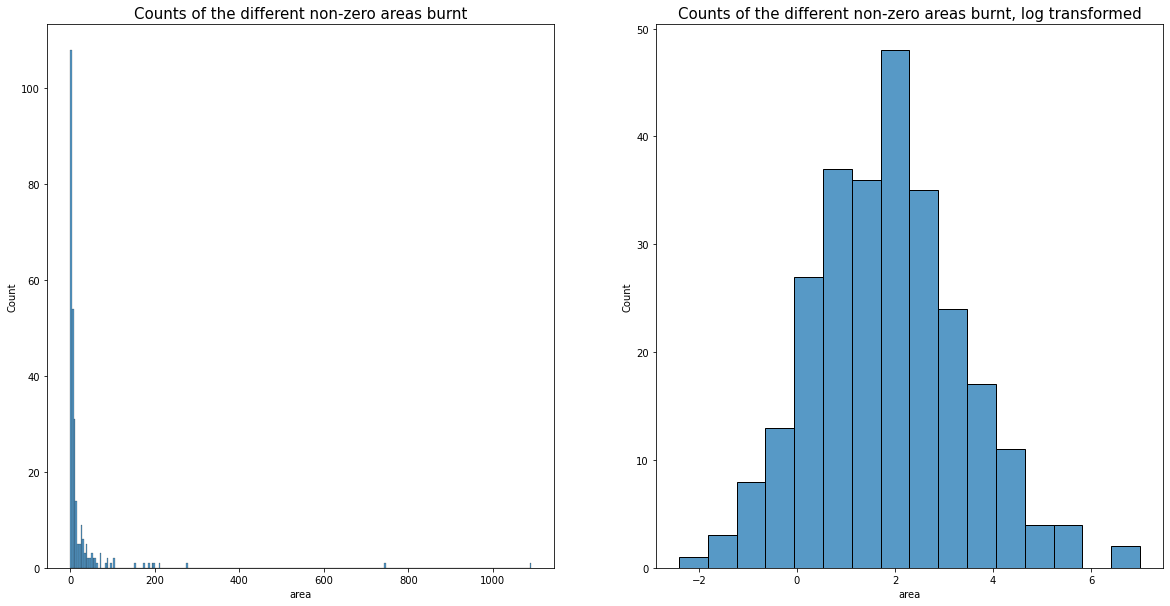

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_nonzero_area(fires, ax=axes[0])
plot_nonzero_area_logtransformed(fires, ax=axes[1])
plt.show()

After removing the 0 entries, and doing a log transformation, the target variable seems to follow a normal distribution

### Exploring "rain"

In [9]:
fires["rain"].value_counts()

0.0    509
0.8      2
0.2      2
0.4      1
1.4      1
6.4      1
1.0      1
Name: rain, dtype: int64

The rain variable seems to be mostly 0, which totally makes sense. After removal of the outlyer, the variable will be binary encoded.

### Exploring FFMC and ISI

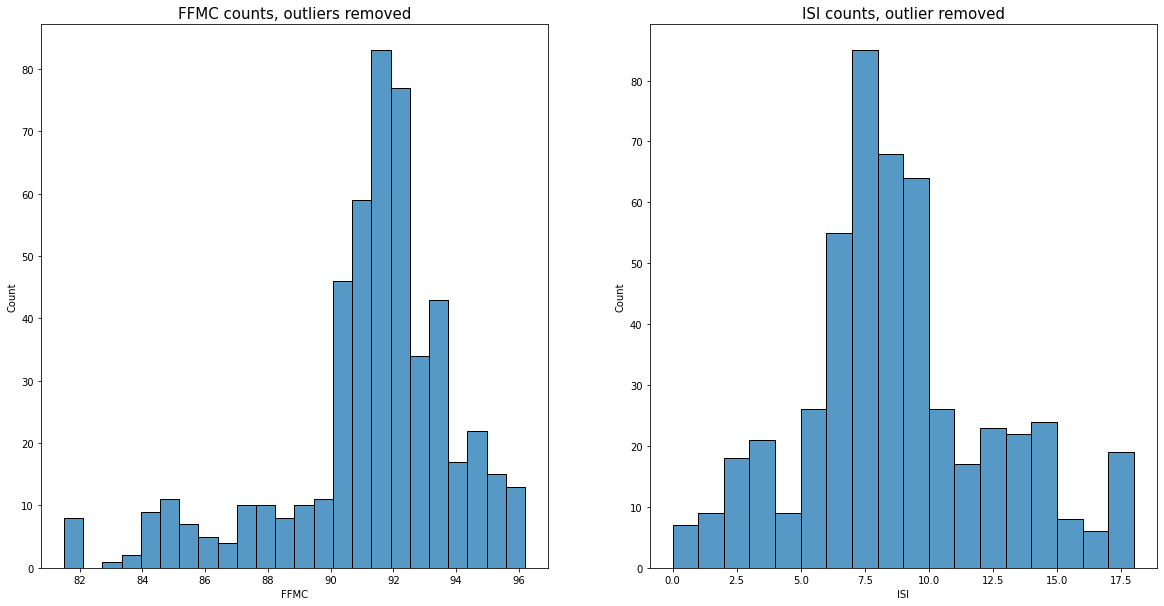

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_ffmc_wo_outliers(fires, ax=axes[0])
plot_ISI_wo_outliers(fires, ax=axes[1])
plt.show()

- The variable FFMC, even after removal of the outliers seems negative skewed. Since probably tree classifiers will be used, probably only the outliers will be removed or one-hot encoded and replaced by the mean
- The situation for ISI is similar.

### Exploring DC

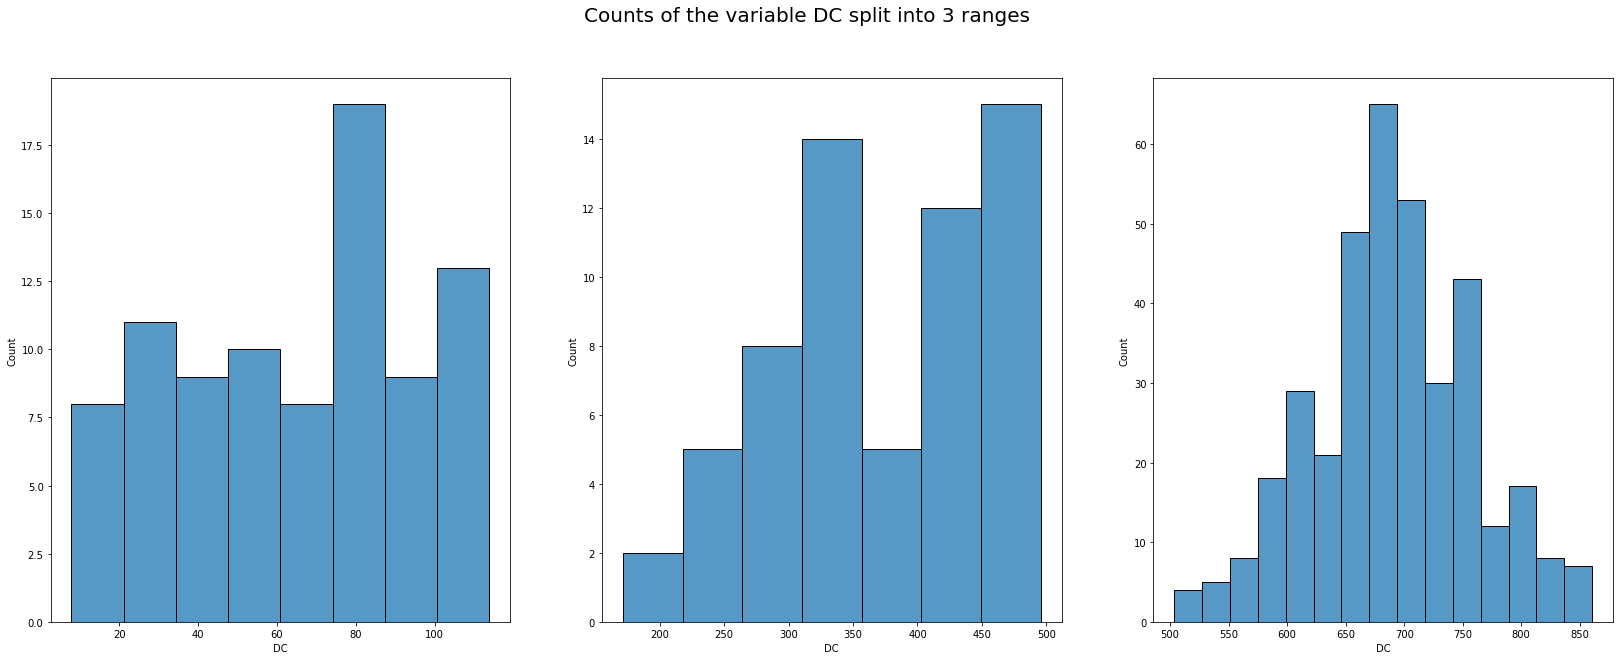

In [11]:
plot_DC_split(fires)

The variable can be apparently divided into two-three disjoint ranges, where most of the counts are in the range [500, 900] and present a distribution apparently close to normality

### Exploring RH

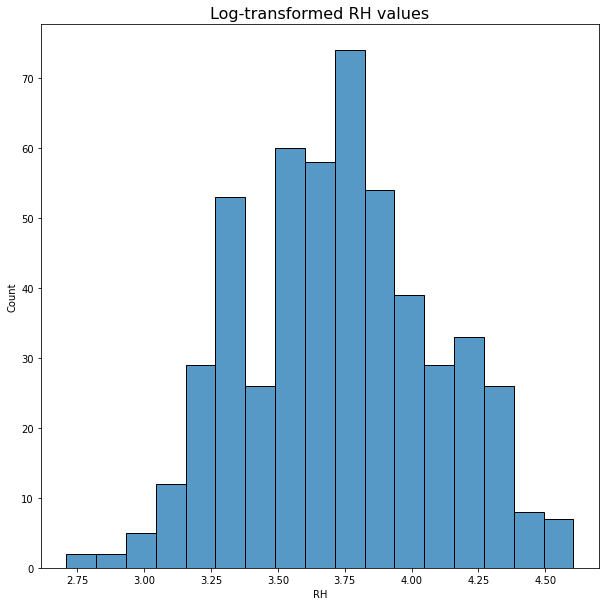

In [12]:
fig = plt.figure(figsize=(10, 10))
g = sns.histplot(np.log(fires["RH"]))
g.set_title("Log-transformed RH values", fontsize = 16)
plt.show()

After log transformation the values seem to follow a normal distribution

## After initial preprocessing

In [81]:
dpp = DataPreprocessor()
dpp.fit(fires)
processed_fires = dpp.transform_with_2target().iloc[:-1] #added extra null row
processed_fires = processed_fires.reset_index()
continuous_cols = ['DC', 'FFMC', 'DMC', 'ISI', 'temp', 'RH', 'wind', 'area']

In [82]:
fires_cont = processed_fires[continuous_cols]

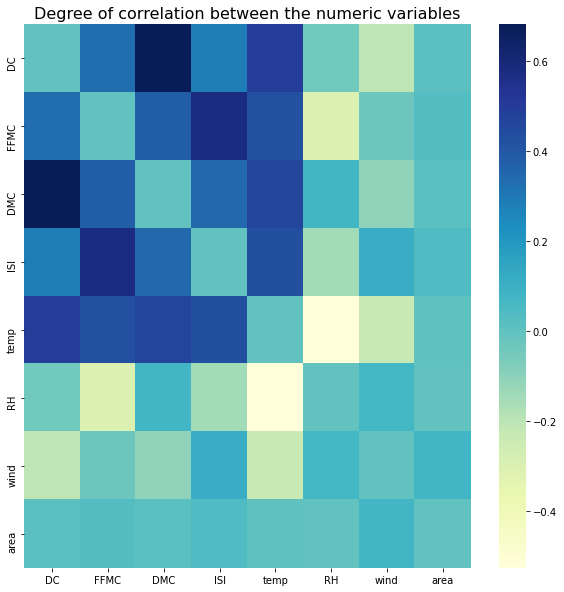

In [83]:
fig = plt.figure(figsize=(10, 10))
corr_test = fires_cont.corr().replace(1, 0)
g = sns.heatmap(corr_test, cmap="YlGnBu")
g.set_title("Degree of correlation between the numeric variables", fontsize=16)
plt.show()

In [84]:
corr_test.iloc[7,:]

DC      0.009559
FFMC    0.034026
DMC     0.013301
ISI     0.044284
temp    0.005660
RH      0.000248
wind    0.074495
area    0.000000
Name: area, dtype: float64

The linear correlation between the numeric variables shows two things:

- There's a high correlation between several of the numeric variables: Hence dimensionality reduction could help improve the model
- The linear correlation between the target variable and the other variables is low: A linear regression model wouldn't be a proper model

In [89]:
processed_fires.to_csv("fire_data_processed.csv")
with open("preprocessor.pickle", "wb") as f:
    pickle.dump(dpp, f)

save the processed data and the processor